In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, make_scorer
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

In [2]:
rs = 42
mi = 10000

sns.set_style("whitegrid")

models = [
    DecisionTreeClassifier(random_state=rs), 
    KNeighborsClassifier(), 
    GaussianNB(), 
    LinearSVC(random_state=rs, max_iter=mi), 
    SVC(random_state=rs, max_iter=mi), 
    LogisticRegression(random_state=rs, max_iter=mi),
    RandomForestClassifier(random_state=rs),
]

train_path = './data/train.csv'
test_path = './data/test.csv'

In [3]:
def make_mi_scores(X, y):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=rs)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(8, 10))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()

def evaluate_for_models(models, X, y):
    results = pd.DataFrame(
        {
            'Model': [],
            'ScoreMean(F1)': [],
            'Score Standard Deviation(F1)': [], 
            'ScoreMean': [],
            'Score Standard Deviation': []
        }
    )
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for model in models:
        score_f1 = cross_val_score(
            model, X, y, cv=stratified_kfold, scoring='f1'
        )
        score = cross_val_score(model, X, y, cv=stratified_kfold)
        new_result = pd.DataFrame({
            'Model': [model.__class__.__name__],
            'ScoreMean(F1)': [score_f1.mean()],
            'Score Standard Deviation(F1)': [score_f1.std()], 
            'ScoreMean': [score.mean()],
            'Score Standard Deviation': [score.std()],
        })
        results = pd.concat([results, new_result], ignore_index=True)

    return results.sort_values(
        by=[
            'ScoreMean(F1)',
            'Score Standard Deviation(F1)',
            'ScoreMean',
            'Score Standard Deviation'
        ],
        ascending=False
    )

### Training

In [4]:
train = pd.read_csv(train_path)
train.head()

,patient,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,...,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at,cancer
0,1,151,72,281,36,29,-299,-336,57,186,...,-156,538,434,168,116,-122,398,188,15091,0
1,2,263,21,250,43,8,-103,-361,169,219,...,-241,863,506,70,94,-40,649,147,11038,0
2,3,88,-27,358,42,11,142,-508,359,237,...,-581,737,770,141,57,-38,701,131,16692,0
3,4,484,61,118,39,38,-11,-116,274,245,...,-267,882,348,102,179,-58,533,448,15763,0
4,5,118,16,197,39,50,237,-129,311,186,...,-235,386,484,123,66,-45,448,106,18128,0


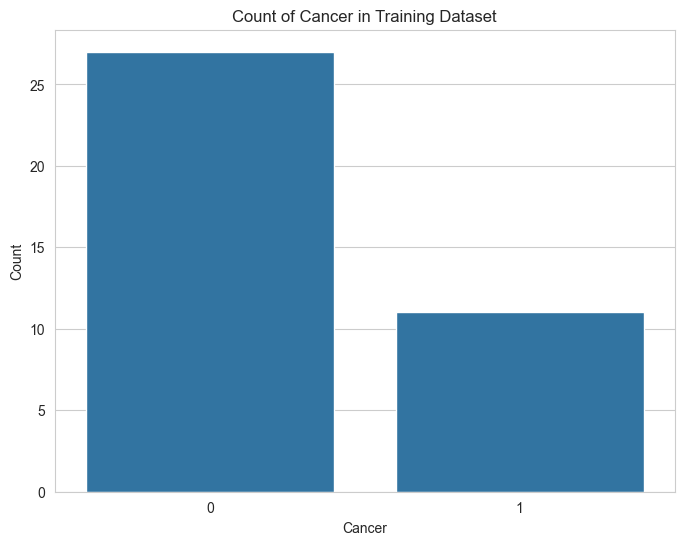

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train, x='cancer')
plt.title('Count of Cancer in Training Dataset')
plt.xlabel('Cancer')
plt.ylabel('Count')
plt.savefig('train.png', dpi=150)
plt.show()

In [6]:
train_X = train.drop(columns=["patient", "cancer"])
train_y = train["cancer"]

In [7]:
scores = make_mi_scores(train_X, train_y)

In [8]:
scores.describe()

count    7129.000000
mean        0.576815
std         0.034739
min         0.369021
25%         0.565198
50%         0.601680
75%         0.601680
max         0.601680
Name: MI Scores, dtype: float64

In [9]:
evaluate_for_models(models, train_X, train_y)

,Model,ScoreMean(F1),Score Standard Deviation(F1),ScoreMean,Score Standard Deviation
2,GaussianNB,1.000000,0.000000,1.000000,0.000000
0,DecisionTreeClassifier,0.933333,0.133333,0.975000,0.050000
3,LinearSVC,0.933333,0.133333,0.975000,0.050000
5,LogisticRegression,0.933333,0.133333,0.975000,0.050000
6,RandomForestClassifier,0.700000,0.163299,0.867857,0.079539
1,KNeighborsClassifier,0.693333,0.369023,0.892857,0.105342
4,SVC,0.000000,0.000000,0.710714,0.045737


### Tuning

In [10]:
gnb_params = {
    'var_smoothing': np.logspace(-9, 0, 100),
}

gnb_scv = RandomizedSearchCV(
    GaussianNB(),
    param_distributions=gnb_params, 
    n_iter=100,
    cv=5,
    verbose=2,
    random_state=rs,
    n_jobs=-1,
    scoring="f1",
)

gnb_scv.fit(train_X, train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GaussianNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'var_smoothing': array([1.00000000e-09, 1.23284674e-09, 1.51991108e-09, 1.87381742e-09,
       2.31012970e-09, 2.84803587e-09, 3.51119173e-09, 4.32876128e-09,
       5.33669923e-09, 6.57933225e-09, 8.11130831e-09, 1.00000000e-08,
       1.23284674e-08, 1.51991108e-08, 1.87381742e-08, 2.31012970e-0...
       8.11130831e-03, 1.00000000e-02, 1.23284674e-02, 1.51991108e-02,
       1.87381742e-02, 2.31012970e-02, 2.84803587e-02, 3.51119173e-02,
       4.32876128e-02, 5.33669923e-02, 6.57933225e-02, 8.11130831e-02,
       1.00000000e-01, 1.23284674e-01, 1.51991108e-01, 1.87381742e-01,
       2.31012970e-01, 2.84803587e-01, 3.51119173e-01, 4.32876128e-01,
       5.33669923e-01, 6.57933225e-01, 8.11130831e-01, 1.00000000e+00])},
                   random_state=42, scoring='f1', verbose=2)

In [11]:
gnb_scv_result = pd.DataFrame(gnb_scv.cv_results_)

gnb_scv_result[
    [
        'param_var_smoothing',
        'mean_test_score',
        'std_test_score',
        'rank_test_score',
    ]
].sort_values(by=['rank_test_score']).head()

,param_var_smoothing,mean_test_score,std_test_score,rank_test_score
49,0.000028,1.0,0.0,1
55,0.000100,1.0,0.0,1
54,0.000081,1.0,0.0,1
53,0.000066,1.0,0.0,1
52,0.000053,1.0,0.0,1


In [12]:
dtc_params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None] + list(range(1, 51)),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None] + list(range(10, 101, 10)),
    'min_impurity_decrease': [0.0, 0.01, 0.02, 0.05, 0.1]
}

dtc_scv = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=rs),
    param_distributions=dtc_params, 
    n_iter=300,
    cv=5,
    verbose=2,
    random_state=rs,
    n_jobs=-1,
    scoring="f1",
)

dtc_scv.fit(train_X, train_y)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END ...............var_smoothing=1.2328467394420684e-09; total time=   0.1s
[CV] END ................var_smoothing=1.519911082952933e-09; total time=   0.1s
[CV] END ................var_smoothing=2.310129700083158e-09; total time=   0.1s
[CV] END ...............var_smoothing=3.5111917342151273e-09; total time=   0.1s
[CV] END ................var_smoothing=5.336699231206302e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.1s
[CV] END ...............var_smoothing=5.3366992312063125e-08; total time=   0.1s
[CV] END ...............var_smoothing=5.3366992312063125e-08; total time=   0.1s
[CV] END ................var_smoothing=2.848035868435805e-07; total time=   0.1s
[CV] END ................var_smoothing=2.8480

[CV] END ...............var_smoothing=1.2328467394420684e-09; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860387e-09; total time=   0.1s
[CV] END ................var_smoothing=2.848035868435805e-09; total time=   0.1s
[CV] END ................var_smoothing=4.328761281083061e-09; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575682e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................var_smoothing=2.310129700083158e-08; total time=   0.1s
[CV] END ................var_smoothing=2.310129700083158e-08; total time=   0.0s
[CV] END ................var_smoothing=4.328761281083061e-08; total time=   0.1s
[CV] END ................var_smoothing=4.328761281083061e-08; total time=   0.1s
[CV] END ................var_smoothing=1.519911082952933e-07; total time=   0.1s
[CV] END ................var_smoothing=1.519911082952933e-07; total time=   0.1s
[CV] END ................var

[CV] END ...............var_smoothing=1.2328467394420684e-09; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860387e-09; total time=   0.1s
[CV] END ................var_smoothing=2.848035868435805e-09; total time=   0.1s
[CV] END ................var_smoothing=4.328761281083061e-09; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575682e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860383e-08; total time=   0.1s
[CV] END ................var_smoothing=4.328761281083061e-08; total time=   0.1s
[CV] END ................var_smoothing=4.328761281083061e-08; total time=   0.1s
[CV] END ................var_smoothing=1.519911082952933e-07; total time=   0.1s
[CV] END ...............var_smoothing=1.8738174228603868e-07; total time=   0.1s
[CV] END ...............var_

[CV] END ...............var_smoothing=1.5199110829529332e-05; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860383e-05; total time=   0.1s
[CV] END ................var_smoothing=8.111308307896872e-05; total time=   0.1s
[CV] END ................var_smoothing=8.111308307896872e-05; total time=   0.1s
[CV] END ................var_smoothing=8.111308307896872e-05; total time=   0.1s
[CV] END ...............................var_smoothing=0.0001; total time=   0.1s
[CV] END ...............var_smoothing=0.00043287612810830614; total time=   0.1s
[CV] END ...............var_smoothing=0.00043287612810830614; total time=   0.1s
[CV] END ...............var_smoothing=0.00043287612810830614; total time=   0.1s
[CV] END ................var_smoothing=0.0005336699231206312; total time=   0.1s
[CV] END .................var_smoothing=0.004328761281083062; total time=   0.1s
[CV] END .................var_smoothing=0.004328761281083062; total time=   0.1s
[CV] END .................va

[CV] END ................var_smoothing=2.310129700083158e-05; total time=   0.1s
[CV] END ................var_smoothing=2.310129700083158e-05; total time=   0.1s
[CV] END ................var_smoothing=0.0001232846739442066; total time=   0.1s
[CV] END ................var_smoothing=0.0001519911082952933; total time=   0.0s
[CV] END ................var_smoothing=0.0001519911082952933; total time=   0.1s
[CV] END ................var_smoothing=0.0001519911082952933; total time=   0.1s
[CV] END ................var_smoothing=0.0006579332246575682; total time=   0.1s
[CV] END ................var_smoothing=0.0008111308307896872; total time=   0.1s
[CV] END ................var_smoothing=0.0008111308307896872; total time=   0.1s
[CV] END ................var_smoothing=0.0008111308307896872; total time=   0.0s
[CV] END ................var_smoothing=0.0028480358684358047; total time=   0.1s
[CV] END ................var_smoothing=0.0028480358684358047; total time=   0.0s
[CV] END ................var

[CV] END ...............var_smoothing=1.2328467394420658e-05; total time=   0.1s
[CV] END ...............var_smoothing=1.2328467394420658e-05; total time=   0.1s
[CV] END ...............var_smoothing=5.3366992312063123e-05; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575683e-05; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575683e-05; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575683e-05; total time=   0.1s
[CV] END ................var_smoothing=0.0002848035868435805; total time=   0.1s
[CV] END ................var_smoothing=0.0003511191734215135; total time=   0.1s
[CV] END ................var_smoothing=0.0003511191734215135; total time=   0.1s
[CV] END ................var_smoothing=0.0003511191734215135; total time=   0.1s
[CV] END ................var_smoothing=0.0015199110829529332; total time=   0.1s
[CV] END .................var_smoothing=0.001873817422860383; total time=   0.1s
[CV] END .................va

[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................var_smoothing=1.873817422860387e-09; total time=   0.1s
[CV] END ................var_smoothing=2.848035868435805e-09; total time=   0.1s
[CV] END ................var_smoothing=4.328761281083061e-09; total time=   0.1s
[CV] END .................var_smoothing=8.11130830789689e-09; total time=   0.1s
[CV] END ................var_smoothing=1.232846739442066e-08; total time=   0.1s
[CV] END ................var_smoothing=1.232846739442066e-08; total time=   0.0s
[CV] END ................var_smoothing=2.848035868435805e-08; total time=   0.1s
[CV] END ................var_smoothing=2.848035868435805e-08; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575682e-08; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575682e-08; total time=   0.1s
[CV] END ................var_smoothing=6.579332246575682e-08; total time=   0.1s
[CV] END ................var

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
380 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
199 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.9/site-packa

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 2, 3, 4, 5, 6, 7,
                                                      8, 9, 10, 11, 12, 13, 14,
                                                      15, 16, 17, 18, 19, 20,
                                                      21, 22, 23, 24, 25, 26,
                                                      27, 28, 29, ...],
                                        'max_features': [None, 'auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90,
                                                           100],
                                        'min_impurity_decrease': [0.0, 0.01,
                                                                  0.02, 0.05,
                                                                  0.1],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1', verbose=2)

In [13]:
dtc_scv_result = pd.DataFrame(dtc_scv.cv_results_)

dtc_scv_result[
    [
        'param_criterion',
        'param_splitter',
        'param_max_depth',
        'param_min_samples_split',
        'param_min_samples_leaf',
        'param_max_features',
        'param_max_leaf_nodes',
        'param_min_impurity_decrease',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]
].sort_values(by=['rank_test_score']).head()

,param_criterion,param_splitter,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,mean_test_score,std_test_score,rank_test_score
54,gini,best,29.0,2,1,None,80.0,0.01,0.933333,0.133333,1
220,entropy,best,24.0,5,2,None,40.0,0.02,0.933333,0.133333,1
205,gini,best,47.0,2,8,None,70.0,0.10,0.933333,0.133333,1
63,entropy,best,32.0,2,8,None,70.0,0.02,0.933333,0.133333,1
71,gini,best,29.0,10,6,None,60.0,0.02,0.933333,0.133333,1


### Model building

In [14]:
gnb = GaussianNB()
gnb.fit(train_X, train_y)

GaussianNB()

In [15]:
pred_y_gnb = gnb.predict(train_X)

In [16]:
f1_score(train_y, pred_y_gnb)

1.0

In [17]:
accuracy_score(train_y, pred_y_gnb)

1.0

In [18]:
dtc = DecisionTreeClassifier(random_state=rs)
dtc.fit(train_X, train_y)

DecisionTreeClassifier(random_state=42)

In [19]:
pred_y_dtc = dtc.predict(train_X)

In [20]:
f1_score(train_y, pred_y_dtc)

1.0

In [21]:
accuracy_score(train_y, pred_y_dtc)

1.0

### Test dataset

In [22]:
test = pd.read_csv(test_path)
test.head()

,patient,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000381_s_at,AB000409_at,AB000410_s_at,AB000449_at,AB000450_at,...,Z84722_at,Z86000_at,Z93784_at,Z94753_s_at,Z95624_at,Z96810_at,Z97054_xpt2_at,Z97074_at,hum_alu_at,cancer
0,39,241,-38,251,98,130,-260,-296,149,275,...,-521,840,277,111,113,-36,299,-132,45815,0
1,40,430,4,131,68,33,181,-282,70,406,...,-46,691,180,84,140,-122,556,165,20958,0
2,41,261,45,123,51,10,125,-57,353,259,...,-162,331,338,-15,111,-43,428,-12,28991,0
3,42,96,31,138,40,33,-120,-270,283,113,...,-110,869,275,192,156,-6,866,88,25880,0
4,43,555,168,149,31,72,134,-124,372,122,...,28,725,216,55,69,2,389,117,42401,0


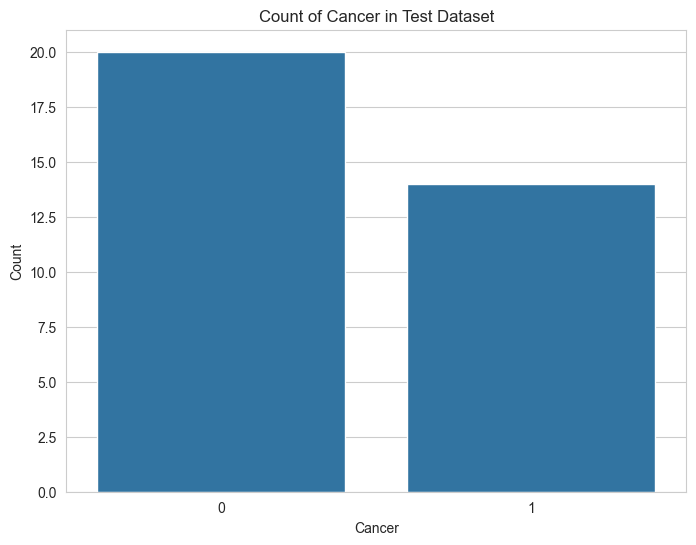

In [23]:
plt.figure(figsize=(8, 6))
sns.countplot(data=test, x='cancer')
plt.title('Count of Cancer in Test Dataset')
plt.xlabel('Cancer')
plt.ylabel('Count')
plt.savefig('test.png', dpi=150)
plt.show()

In [24]:
test_X = test.drop(columns=["patient", "cancer"])
test_y = test["cancer"]

### gnb

In [25]:
pred_y_gnb = gnb.predict(test_X)

In [26]:
f1_score(test_y, pred_y_gnb)

0.896551724137931

In [27]:
accuracy_score(test_y, pred_y_gnb)

0.9117647058823529

In [28]:
print(classification_report(test_y, pred_y_gnb))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



In [29]:
cm = confusion_matrix(test_y, pred_y_gnb)

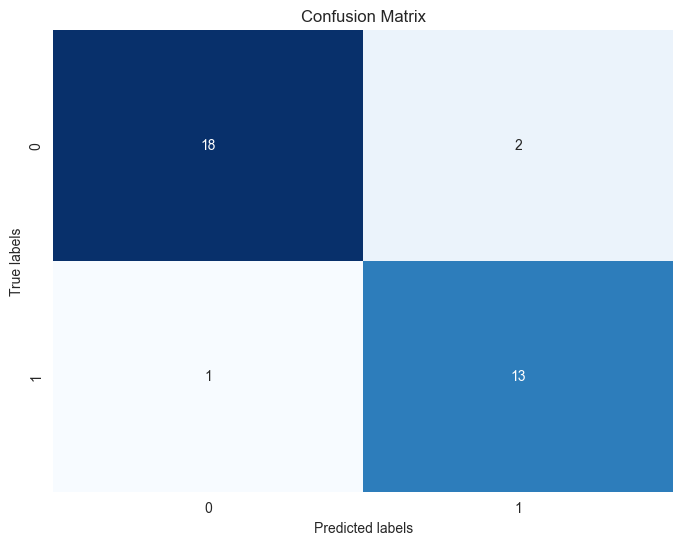

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('test-cm-gnb.png', dpi=150)
plt.show()

### dtc

In [31]:
pred_y_dtc = dtc.predict(test_X)

In [32]:
f1_score(test_y, pred_y_dtc)

0.896551724137931

In [33]:
accuracy_score(test_y, pred_y_dtc)

0.9117647058823529

In [34]:
print(classification_report(test_y, pred_y_dtc))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        20
           1       0.87      0.93      0.90        14

    accuracy                           0.91        34
   macro avg       0.91      0.91      0.91        34
weighted avg       0.91      0.91      0.91        34



In [35]:
cm = confusion_matrix(test_y, pred_y_dtc)

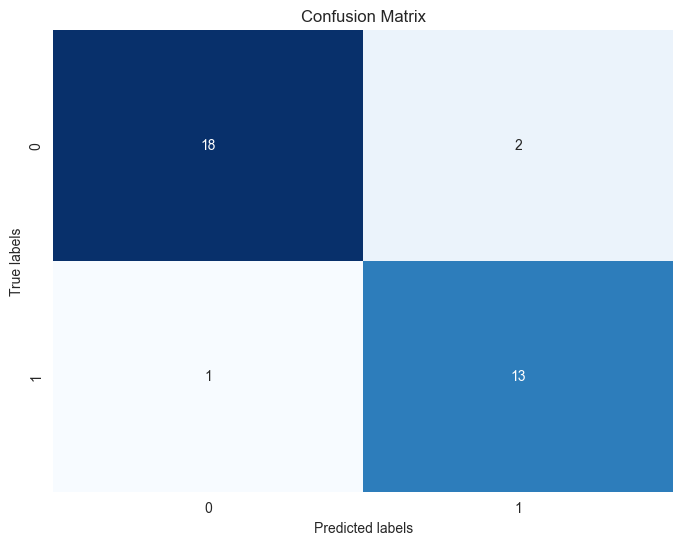

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('test-cm-dtc.png', dpi=150)
plt.show()

### XAI

In [37]:
dtc.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [38]:
dtc.feature_importances_.mean()

0.00014027212792818068

In [39]:
dtc.feature_importances_.sum()

1.0

In [40]:
fi_df = pd.DataFrame({
    'Feature': train_X.columns,
    'Importance': dtc.feature_importances_
})
fi_df = fi_df.sort_values(by='Importance', ascending=False)
fi_df['Importance'] = fi_df['Importance'].apply(lambda x: format(x, '.10f'))

fi_df

,Feature,Importance
6612,X95735_at,1.0000000000
0,A28102_at,0.0000000000
4749,U57316_at,0.0000000000
4759,U57627_at,0.0000000000
4758,U57623_s_at,0.0000000000
...,...,...
2373,M15205_at,0.0000000000
2372,M15182_at,0.0000000000
2371,M15169_at,0.0000000000
2370,M15059_at,0.0000000000


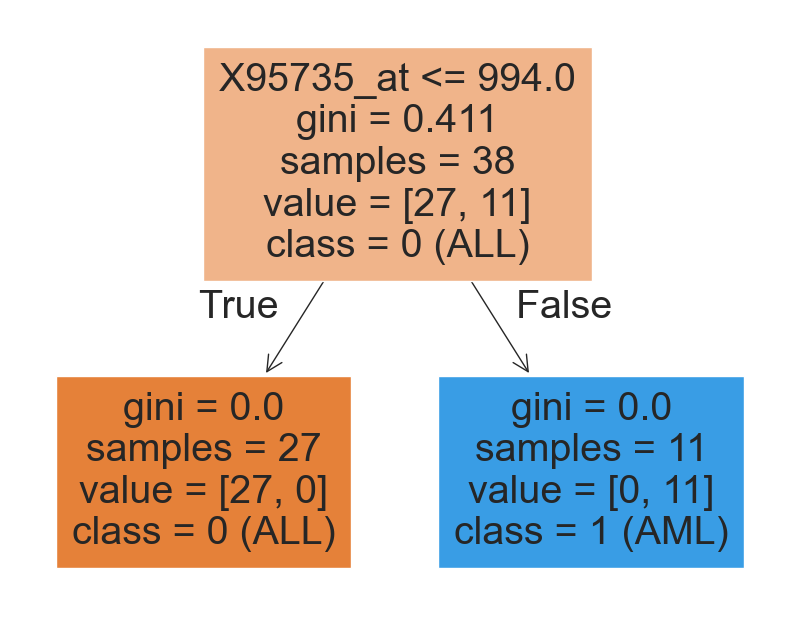

In [41]:
plt.figure(figsize=(10, 8))
plot_tree(dtc, filled=True, feature_names=train_X.columns, class_names=["0 (ALL)", "1 (AML)"])
plt.savefig('tree.png', dpi=150)
plt.show()

### Clustering

In [42]:
n_clusters = 2

In [43]:
kmeans = KMeans(n_clusters=n_clusters, random_state=rs)
kmeans.fit(train_X)

KMeans(n_clusters=2, random_state=42)

In [44]:
markers = {0: 'o', 1: 's'}
cluster_palette = sns.color_palette()

### train data

In [45]:
pred_y_kmc = kmeans.labels_

In [46]:
f1_score(train_y, pred_y_kmc)

0.7096774193548387

In [47]:
accuracy_score(train_y, pred_y_kmc)

0.7631578947368421

In [48]:
print(classification_report(train_y, pred_y_kmc))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        27
           1       0.55      1.00      0.71        11

    accuracy                           0.76        38
   macro avg       0.78      0.83      0.75        38
weighted avg       0.87      0.76      0.77        38



In [49]:
cm = confusion_matrix(train_y, pred_y_kmc)

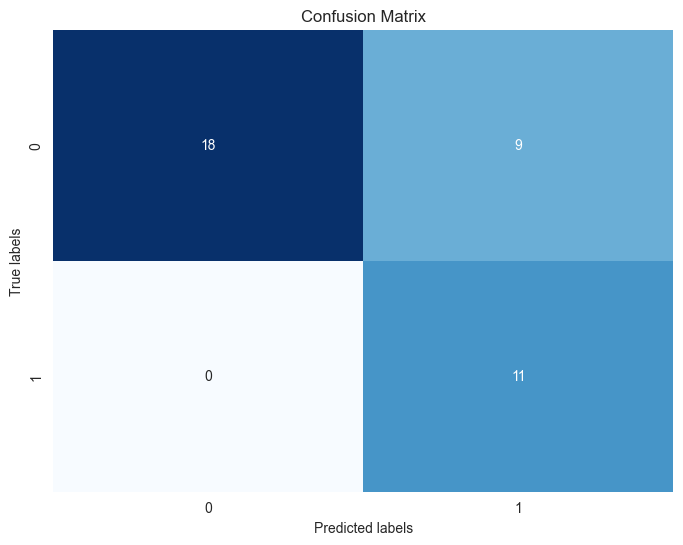

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('train-cm-kmc.png', dpi=150)
plt.show()

In [51]:
pca_2 = PCA(n_components=2)
principal_components_2 = pca_2.fit_transform(train_X)
df_pca_2 = pd.DataFrame(data=principal_components_2, columns=['PC1', 'PC2'])
df_pca_2['cluster'] = pred_y_kmc
df_pca_2['true_label'] = train_y

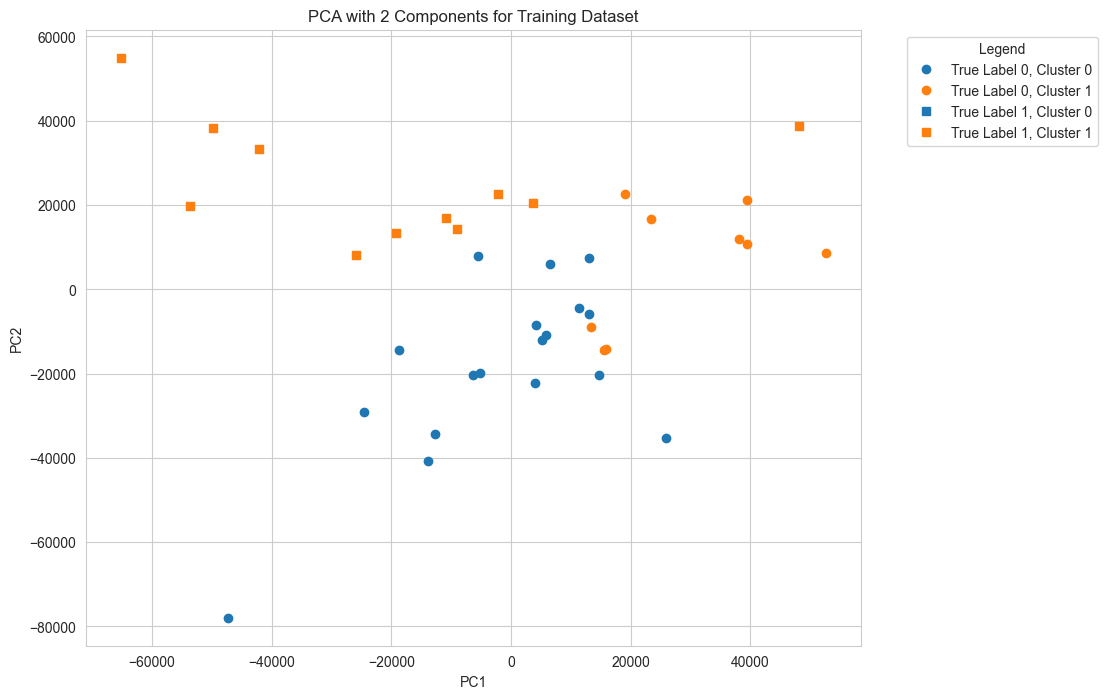

In [52]:
plt.figure(figsize=(10, 8))
for true_label in df_pca_2['true_label'].unique():
    for cluster in df_pca_2['cluster'].unique():
        subset = df_pca_2[(df_pca_2['true_label'] == true_label) & (df_pca_2['cluster'] == cluster)]
        plt.scatter(subset['PC1'], subset['PC2'], marker=markers[true_label], color=cluster_palette[cluster], label=f'True Label {true_label}, Cluster {cluster}')

handles = []
for true_label in markers.keys():
    for cluster in range(n_clusters):
        handles.append(plt.Line2D([0], [0], marker=markers[true_label], color=cluster_palette[cluster], linestyle='', label=f'True Label {true_label}, Cluster {cluster}'))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('PCA with 2 Components for Training Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('train-2.png', dpi=150, bbox_inches='tight')
plt.show()

In [53]:
pca_3 = PCA(n_components=3)
principal_components_3 = pca_3.fit_transform(train_X)
df_pca_3 = pd.DataFrame(data=principal_components_3, columns=['PC1', 'PC2', 'PC3'])
df_pca_3['cluster'] = pred_y_kmc
df_pca_3['true_label'] = train_y

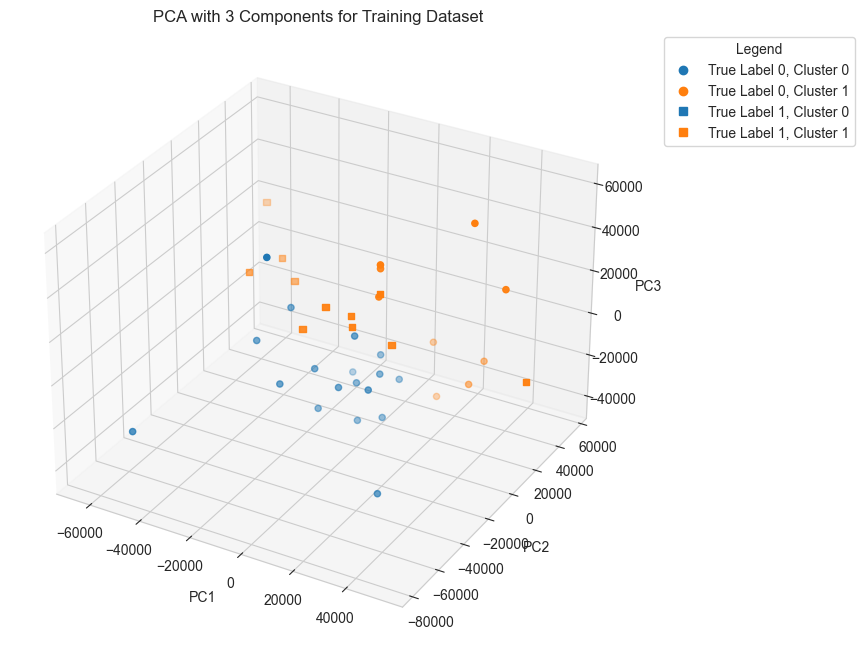

In [54]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for true_label in df_pca_3['true_label'].unique():
    for cluster in df_pca_3['cluster'].unique():
        subset = df_pca_3[(df_pca_3['true_label'] == true_label) & (df_pca_3['cluster'] == cluster)]
        ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], marker=markers[true_label], color=cluster_palette[cluster], label=f'True Label {true_label}, Cluster {cluster}')

handles = []
for true_label in markers.keys():
    for cluster in range(n_clusters):
        handles.append(plt.Line2D([0], [0], marker=markers[true_label], color=cluster_palette[cluster], linestyle='', label=f'True Label {true_label}, Cluster {cluster}'))
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

ax.set_title('PCA with 3 Components for Training Dataset')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.savefig('train-3.png', dpi=150, bbox_inches='tight')
plt.show()

### test data

In [55]:
pred_y_kmc = kmeans.predict(test_X)

In [56]:
f1_score(test_y, pred_y_kmc)

0.7027027027027027

In [57]:
accuracy_score(test_y, pred_y_kmc)

0.6764705882352942

In [58]:
print(classification_report(test_y, pred_y_kmc))

              precision    recall  f1-score   support

           0       0.91      0.50      0.65        20
           1       0.57      0.93      0.70        14

    accuracy                           0.68        34
   macro avg       0.74      0.71      0.67        34
weighted avg       0.77      0.68      0.67        34



In [59]:
cm = confusion_matrix(test_y, pred_y_kmc)

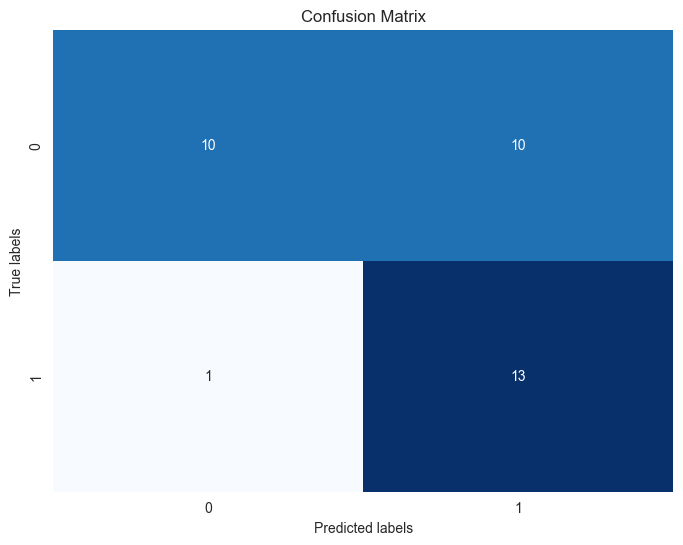

In [60]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('test-cm-kmc.png', dpi=150)
plt.show()

In [61]:
principal_components_2 = pca_2.transform(test_X)
df_pca_2 = pd.DataFrame(data=principal_components_2, columns=['PC1', 'PC2'])
df_pca_2['cluster'] = pred_y_kmc
df_pca_2['true_label'] = test_y

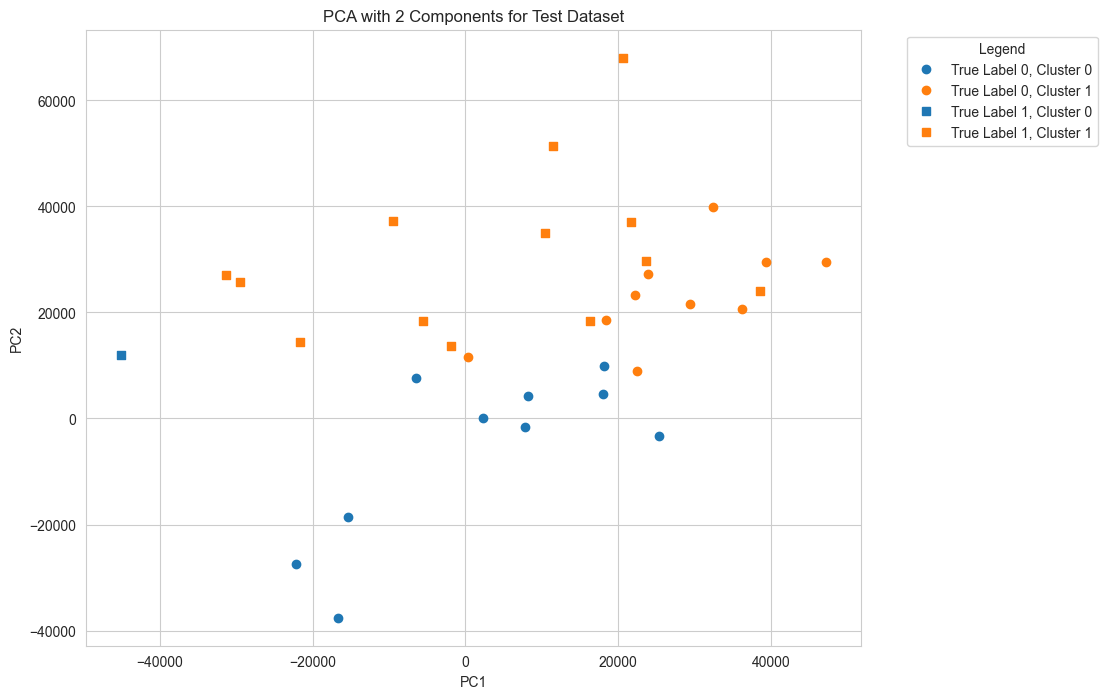

In [62]:
plt.figure(figsize=(10, 8))
for true_label in df_pca_2['true_label'].unique():
    for cluster in df_pca_2['cluster'].unique():
        subset = df_pca_2[(df_pca_2['true_label'] == true_label) & (df_pca_2['cluster'] == cluster)]
        plt.scatter(subset['PC1'], subset['PC2'], marker=markers[true_label], color=cluster_palette[cluster], label=f'True Label {true_label}, Cluster {cluster}')

handles = []
for true_label in markers.keys():
    for cluster in range(n_clusters):
        handles.append(plt.Line2D([0], [0], marker=markers[true_label], color=cluster_palette[cluster], linestyle='', label=f'True Label {true_label}, Cluster {cluster}'))
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

plt.title('PCA with 2 Components for Test Dataset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.savefig('test-2.png', dpi=150, bbox_inches='tight')
plt.show()

In [63]:
principal_components_3 = pca_3.transform(test_X)
df_pca_3 = pd.DataFrame(data=principal_components_3, columns=['PC1', 'PC2', 'PC3'])
df_pca_3['cluster'] = pred_y_kmc
df_pca_3['true_label'] = test_y

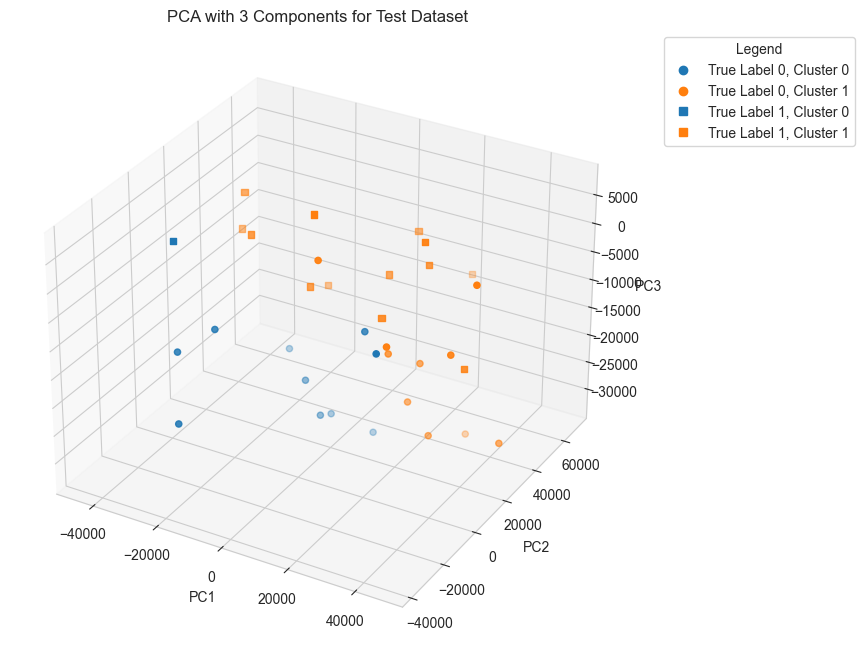

[CV] END criterion=gini, max_depth=3, max_features=auto, max_leaf_nodes=90, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=3, max_features=auto, max_leaf_nodes=90, min_impurity_decrease=0.05, min_samples_leaf=2, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=2, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=42, max_features=sqrt, max_leaf_nodes=80, min_impurity_

[CV] END criterion=gini, max_depth=49, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=5, splitter=random; total time=   0.1s
[CV] END criterion=entropy, max_depth=7, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.1, min_samples_leaf=6, min_samples_split=10, splitter=best; total time=   0.1s
[CV] END criterion=gini, max_depth=14, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=2, splitter=best; total time=   0.1s
[CV] END criterion=gini, max_depth=14, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=2, splitter=best; total time=   0.1s
[CV] END criterion=gini, max_depth=14, max_features=sqrt, max_leaf_nodes=80, min_impurity_decrease=0.02, min_samples_leaf=8, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=1, max_features=auto, max_leaf_nodes=80, min_impurity_decreas

[CV] END criterion=gini, max_depth=31, max_features=None, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=10, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=31, max_features=None, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=10, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=31, max_features=None, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=6, min_samples_split=10, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=22, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=1, min_samples_split=20, splitter=best; total time=   0.1s
[CV] END criterion=gini, max_depth=22, max_features=sqrt, max_leaf_nodes=10, min_impurity_decrease=0.02, min_samples_leaf=1, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=36, max_features=log2, max_leaf_nodes=50, min_impur

[CV] END criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=20, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=2, max_features=sqrt, max_leaf_nodes=60, min_impurity_decrease=0.01, min_samples_leaf=1, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=15, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=15, max_features=auto, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=8, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=32, max_features=log2, max_leaf_nodes=30, min_impurity_decrease=0.1, min_samples_leaf=8, min_samples_split=20, splitter=best; total time=   0.1s
[CV] END criterion=gini, max_depth=32, max_features=log2, max_leaf_nodes=30, min_impurity_decr

[CV] END criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=60, min_impurity_decrease=0.05, min_samples_leaf=6, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=60, min_impurity_decrease=0.05, min_samples_leaf=6, min_samples_split=20, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=60, min_impurity_decrease=0.05, min_samples_leaf=6, min_samples_split=20, splitter=random; total time=   0.1s
[CV] END criterion=gini, max_depth=13, max_features=sqrt, max_leaf_nodes=60, min_impurity_decrease=0.05, min_samples_leaf=6, min_samples_split=20, splitter=random; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, max_leaf_nodes=20, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=2, splitter=best; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, max_leaf_nodes=20, mi

In [64]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for true_label in df_pca_3['true_label'].unique():
    for cluster in df_pca_3['cluster'].unique():
        subset = df_pca_3[(df_pca_3['true_label'] == true_label) & (df_pca_3['cluster'] == cluster)]
        ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], marker=markers[true_label], color=cluster_palette[cluster], label=f'True Label {true_label}, Cluster {cluster}')

handles = []
for true_label in markers.keys():
    for cluster in range(n_clusters):
        handles.append(plt.Line2D([0], [0], marker=markers[true_label], color=cluster_palette[cluster], linestyle='', label=f'True Label {true_label}, Cluster {cluster}'))
ax.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

ax.set_title('PCA with 3 Components for Test Dataset')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.savefig('test-3.png', dpi=150, bbox_inches='tight')
plt.show()